## Global Estimates
From Nycander [2005], Llewellyn Smith & Young [2002], Zilberman et al. [2009]

Domain integrated conversion rates: 
* per modes
* inifinite depth limite
* finite depth approx. using spectral filter)

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.stats as stats
from netCDF4 import Dataset
#from SW_Density import SW_Density as rhop # temporary
from comp_rho import rhop
from pad_coords import pad_coords   # for padding fields outside of domain
import time
from dynmodes_fs import dynmodes_fs

doverb = True


In [8]:
import dynmodes_fs
help(dynmodes_fs.dynmodes_fs)

Help on function dynmodes_fs in module dynmodes_fs:

dynmodes_fs(Nsq, depth, nmodes, fs=True)
    Calculate the 1st nmodes ocean dynamic vertical modes
    given a profile of Brunt-Vaisala (buoyancy) frequencies squared.
    
    Based on http://woodshole.er.usgs.gov/operations/sea-mat/klinck-html/dynmodes.html
    by John Klinck, 1999.
    
    :arg Nsq: Brunt-Vaisala (buoyancy) frequencies squared in [1/s^2]
    :type Nsq: :class:`numpy.ndarray`
    
    :arg depth: Depths in [m] (increasing, algebraic or absolute)
    :type depth: :class:`numpy.ndarray`
    
    :arg nmodes: Number of modes to calculate
    :type nmodes: int
    
    :arg fs: switch for free surface (True, default) or rigid lid
    :type fs: boolean
    
    :returns: :obj:`(wmodes, pmodes, ce)` vertical velocity modes,
              horizontal velocity modes, modal speeds
    :rtype: tuple of :class:`numpy.ndarray`



In [10]:
# --- data location ---
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky" # "tpxo" # "srtm"
if topo == 'lucky':
    file_topo = path_data+"lucky_grd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'
elif topo == 'srtm':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO
elif topo == 'tpxo8':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO

# --- tide dataset --- 
tide = 'tpxo8' #'lucky' #

if tide == 'lucky':
    uname = path_data+'luckym2_frc.nc' 
elif tide == 'tpxo8':
    uname = "/net/ruchba/local/tmp/2/lahaye/TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc"
    hname = uname.replace("uv.m2","grid")
    
zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
M2         = 2*np.pi/12.42          # M2 tide frequency [rad/hour] 
Erad = 6371e3                  # Earth radius [m]

In [36]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = -nc.variables[varh][:].T
    h_t[h_t>=-2.5] = 0     # land points   # "raw" topo (for FFT)
    h_ma = np.ma.masked_where(h_t==0,-h_t) # masked topo
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T # grid angle (between xi and E, radians)
nc.close()

#dhdx = np.diff(h_t,axis=0)/0.5/(dx_h[1:,:]+dx_h[:-1,:])
#dhdx = np.r_[dhdx[:1,:]/2.,(dhdx[1:,:]+dhdx[:-1,:])/2,dhdx[-1:,:]/2.]
#dhdy = np.diff(h_t,axis=1)/0.5/(dy_h[:,1:]+dy_h[:,:-1])
#dhdy = np.c_[dhdy[:,:1]/2.,(dhdy[:,1:]+dhdy[:,:-1])/2,dhdy[:,-1:]/2.]
dhdx, dhdy = np.gradient(h_t,dx_h.mean(),dy_h.mean())

fcor = 2.*(2*np.pi/24.)*np.sin(lat_h*np.pi/180.).mean() # coriolis, rad/hour

In [16]:
# ------ extract Tides ------------------------------

if tide == 'lucky':
    nc = Dataset(uname,'r')
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T*np.pi/180.
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T*np.pi/180.
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
elif tide == 'tpxo8':
    nch = Dataset(hname,'r')
    ncvar = nch.variables
    latu = ncvar['lat_u'][:]
    lonu = ncvar['lon_u'][:]
    #lonu[lonu>180] -= 360
    latv = ncvar['lat_v'][:]
    lonv = ncvar['lon_v'][:]
    #lonv[lonv>180] -= 360
    indxu, = np.where( (lonu>=(lon_h%360).min()) & (lonu<=(lon_h%360).max()) )
    indxv, = np.where( (lonv>=(lon_h%360).min()) & (lonv<=(lon_h%360).max()) )
    indyu, = np.where( (latu>=lat_h.min()) & (latu<=lat_h.max()) )
    indyv, = np.where( (latv>=lat_h.min()) & (latv<=lat_h.max()) )
    hu = ncvar['hu'][indxu,indyu]
    hv = ncvar['hv'][indxv,indyv]
    nch.close()
    nc = Dataset(uname,'r')
    ncvar = nc.variables
    ure = ncvar['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m²/s
    vre = ncvar['vRe'][indxv,indyv]*1e-4/hv
    uim = ncvar['uIm'][indxu,indyu]*1e-4/hu
    vim = ncvar['vIm'][indxv,indyv]*1e-4/hv  
    del hu, hv
    nc.close()

# conversion to grid coordinates
if tide == 'lucky':
    ubt = ue*np.cos(phi-gang)*np.cos(pha) - ve*np.sin(phi-gang)*np.sin(pha)
    vbt = ue*np.sin(phi-gang)*np.cos(pha) + ve*np.cos(phi-gang)*np.sin(pha)
elif tide == 'tpxo8':
    # interpolate on h_grid
    #ure = itp.griddata((np.ravel(lonu),np.ravel(latu)),np.ravel(ua_tmp),(lon2d,lat2d)
    ure = interp.RectBivariateSpline(lonu[indxu], latu[indyu], np.nan_to_num(ure)).ev(lon_h%360,lat_h%360)
    vre = interp.RectBivariateSpline(lonv[indxv], latv[indyv], np.nan_to_num(vre)).ev(lon_h%360,lat_h%360)
    uim = interp.RectBivariateSpline(lonu[indxu], latu[indyu], np.nan_to_num(uim)).ev(lon_h%360,lat_h%360)
    vim = interp.RectBivariateSpline(lonv[indxv], latv[indyv], np.nan_to_num(vim)).ev(lon_h%360,lat_h%360)
    pha = np.arctan2(-vim,vre) - np.arctan2(-uim,ure)
    ua = np.abs(ure + 1j*uim)    
    va = np.abs(vre + 1j*vim)
        
    ubt = ua*np.cos(gang) + va*np.sin(gang)
    vbt = -ua*np.sin(gang) + va*np.cos(gang)
    del ure, vre, uim, vim, ua, va

/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [57]:
# ------ extract density profile, compute N2 ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size
    
rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = interp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # take routine
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = interp.pchip(zz[::-1],N2_tmp,extrapolate=True)    


# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope
Nb = np.sqrt(fN2(h_t))

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))
    
coef = rho0*Nb/2*np.sqrt(1-fcor**2/M2**2)
kn = lambda n: np.sqrt(M2**2-fcor**2)*n*np.pi/N0/h_ma/3600. # should be bar(N)
kone = np.nanmean(kn(1))
print('1st mode mean hor. wavelength: {} km'.format(2*np.pi/kone/1e3))

had to resort stratif for 2 values
exponential interpolation for stratification: N0=0.003197301906220173, b=1499.5445426309552


/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


1st mode mean hor. wavelength: 132.98414784637745 km


In [67]:
### compute vertical modes (mean depth)
# that is necessary for non-wkb estimates
hmoy = h_ma.mean()
zmod = np.linspace(0,hmoy,100)
N2mod = fN2(-zmod)
wmod, pmod, Cn = dynmodes_fs(N2mod,zmod,10,fs=False)
kapn = np.sqrt(M2**2-fcor**2)/Cn/3600.

wbot = ((wmod[:,-2]-wmod[:,-1])/(zmod[-2]-zmod[-1]))**2/np.trapz(wmod**2,zmod,axis=-1)


In [71]:
### Llewellyn Smith & Young [2002], eq. (37)
coef = rho0*fcor*(ubt**2+vbt**2)*np.sqrt(1-fcor**2/M2**2)
coen = wbot*Cn*(fcor/3600.)*(M2**2/fcor**2-1)   # eps_n*sig_n²*kap_n² in (37)

### 2D Fourier(topo)
npad = 500
dowin = False

if doverb:
    tmes, tmeb = time.clock(), time.time()

if npad > 0:
    h = np.pad(h_t,npad,'edge')
else:
    h = h_t.copy()
#h = detrend_2d(h) # apply bilinear detrend
nx, ny = h.shape
dxi, dyi = dx_h.mean(), dy_h.mean()
kx = np.fft.fftfreq(nx,dxi)*2*np.pi    # wavenumbers in x-direction = major axis
ky = np.fft.fftfreq(ny,dyi)*2*np.pi    # wavenumbers in x-direction = major axis
dkx, dky = kx[1]-kx[0], ky[1]-ky[0]
modk = np.sqrt(kx[:,None]**2 + ky[None,:]**2)
if dowin:
    win_x = np.hanning(nx)[None,:]  # window before filtering 
    win_y = np.hanning(ny)[:,None]
else:
    win_x = np.ones((1,nx))
    win_y = np.ones((ny,1))
win = np.dot(win_y,win_x)
int_rec = nx*ny             # integral of a squared rectangular window (as if no windowing) 
int_win = np.nansum(win**2) # integral of the squared window 
norm    = (int_rec/int_win)*1/(nx*ny*dkx*dky) # [1/(rad m-1)^2] normalization constant 
if doverb:
    print('ready for FFT',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()
tfh = np.fft.fft2(h*win)

phi = np.linspace(0,2*np.pi,nlon_h)
kxn = kapn[:,None]*np.cos(phi)[None,:]
kyn = kapn[:,None]*np.sin(phi)[None,:]
#tfh = interp.RectBivariateSpline(np.fft.fftshift(kx),np.fft.fftshift(ky),np.fft.fftshift(tfh)).ev(kxn,kyn)

sigma = 1 + (ubt**2-vbt**2)/(ubt**2+vbt**2)*np.cos(2*phi) \
        + 2*ubt**2*np.cos(pha)/(ubt**2+vbt**2)*np.sin(2*phi)
    

ready for FFT 0.6206129999999916 0.19484734535217285


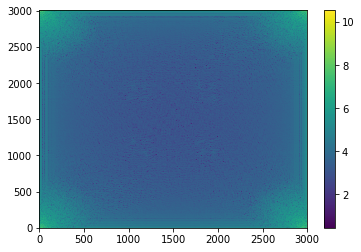

In [91]:
plt.pcolormesh(np.log10(np.abs(tfh)))
plt.colorbar()